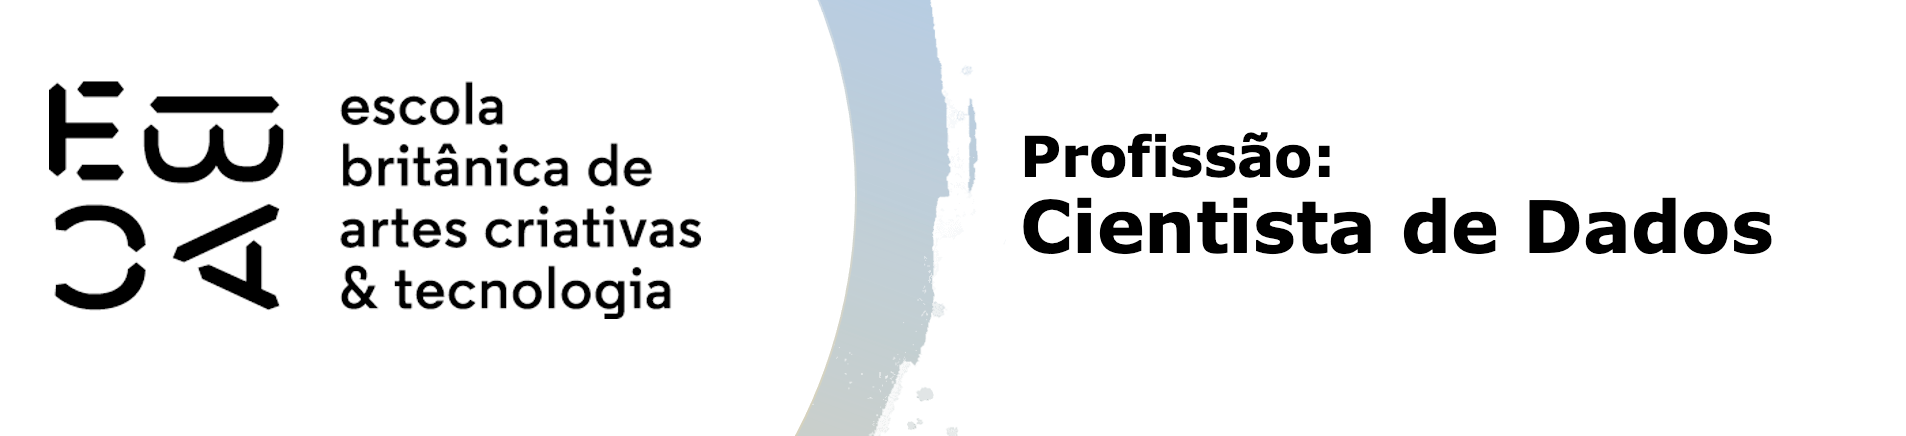

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Carregar a base de dados
file_path = 'base_nfp.pkl'
df = pd.read_pickle(file_path)

## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [3]:
# Converter a coluna 'Data Emissão' para datetime
df['Data Emissão'] = pd.to_datetime(df['Data Emissão'])

# Filtrar os dados a partir de janeiro de 2020
df_filtered = df.loc[df['Data Emissão'] >= '2020-01-01'].copy()

# Criar uma coluna para indicar se teve retorno
df_filtered['flag_retorno'] = df_filtered['Retorno'] > 0

# Criar variáveis temporais
df_filtered['Dia da Semana'] = df_filtered['Data Emissão'].dt.dayofweek  # 0 = Segunda, 6 = Domingo
df_filtered['Fim de Semana'] = df_filtered['Dia da Semana'].isin([5, 6]).astype(int)  # 1 se for sábado ou domingo
df_filtered['Dia do Mês'] = df_filtered['Data Emissão'].dt.day
df_filtered['Trimestre'] = df_filtered['Data Emissão'].dt.quarter

# Categorizações da variável Valor NF
df_filtered['Valor_5Q'] = pd.qcut(df_filtered['Valor NF'], q=5, labels=False)
df_filtered['Valor_10Q'] = pd.qcut(df_filtered['Valor NF'], q=10, labels=False)
df_filtered['Valor_20Q'] = pd.qcut(df_filtered['Valor NF'], q=20, labels=False)
df_filtered['Valor_50Q'] = pd.qcut(df_filtered['Valor NF'], q=50, labels=False)

# Exibir as primeiras linhas para verificar as novas variáveis
print(df_filtered[['Data Emissão', 'Dia da Semana', 'Fim de Semana', 'Dia do Mês', 'Trimestre', 'Valor NF', 'Valor_5Q', 'Valor_10Q', 'Valor_20Q', 'Valor_50Q']].head())

      Data Emissão  Dia da Semana  Fim de Semana  Dia do Mês  Trimestre  \
64598   2020-01-01              2              0           1          1   
64599   2020-01-01              2              0           1          1   
64600   2020-01-01              2              0           1          1   
64601   2020-01-01              2              0           1          1   
64602   2020-01-01              2              0           1          1   

       Valor NF  Valor_5Q  Valor_10Q  Valor_20Q  Valor_50Q  
64598     78.80         2          5         11         27  
64599     22.71         0          1          3          9  
64600     35.90         1          3          6         15  
64601     21.77         0          1          3          8  
64602     80.95         2          5         11         28  


## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [5]:
# Função para calcular WOE e IV
def calculate_woe_iv(df, feature, target):
    df_woe = df.groupby(feature)[target].agg(['sum', 'count']).reset_index()
    df_woe.columns = [feature, 'Eventos', 'Total']
    df_woe['Não Eventos'] = df_woe['Total'] - df_woe['Eventos']
    
    # Evitar log(0) adicionando uma pequena constante
    df_woe['Eventos'] = df_woe['Eventos'].replace(0, 0.5)
    df_woe['Não Eventos'] = df_woe['Não Eventos'].replace(0, 0.5)
    
    # Calcular proporções
    df_woe['Pct_Eventos'] = df_woe['Eventos'] / df_woe['Eventos'].sum()
    df_woe['Pct_Nao_Eventos'] = df_woe['Não Eventos'] / df_woe['Não Eventos'].sum()
    
    # Calcular WOE
    df_woe['WOE'] = np.log(df_woe['Pct_Eventos'] / df_woe['Pct_Nao_Eventos'])
    
    # Calcular IV
    df_woe['IV'] = (df_woe['Pct_Eventos'] - df_woe['Pct_Nao_Eventos']) * df_woe['WOE']
    iv_value = df_woe['IV'].sum()
    
    return iv_value

# Criar metadados e calcular IV para todas as variáveis
variaveis = ['Dia da Semana', 'Fim de Semana', 'Dia do Mês', 'Trimestre', 'Valor_5Q', 'Valor_10Q', 'Valor_20Q', 'Valor_50Q']
iv_results = {var: calculate_woe_iv(df_filtered, var, 'flag_retorno') for var in variaveis}

# Exibir os IVs calculados
iv_df = pd.DataFrame(list(iv_results.items()), columns=['Variável', 'Information Value'])
print(iv_df)

        Variável  Information Value
0  Dia da Semana           0.005878
1  Fim de Semana           0.004599
2     Dia do Mês           0.015128
3      Trimestre           0.003554
4       Valor_5Q           0.038990
5      Valor_10Q           0.059107
6      Valor_20Q           0.078348
7      Valor_50Q           0.122257


## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

#### Quais variáveis apresentam maior poder de discriminação segundo o IV?

Os valores de **Information Value (IV)** indicam o poder preditivo das variáveis em relação à capacidade de discriminar entre notas fiscais que geram e não geram retorno.

- As variáveis **baseadas no valor da nota fiscal (Valor_5Q, Valor_10Q, Valor_20Q e Valor_50Q)** apresentaram os maiores IVs, indicando que o **valor da nota fiscal é um fator relevante para determinar se haverá retorno**.
- **Valor_50Q (IV = 0.1223)** foi a variável com maior poder preditivo, seguido por **Valor_20Q (IV = 0.0783)** e **Valor_10Q (IV = 0.0591)**.
- Variáveis temporais, como **Dia da Semana (IV = 0.0058)** e **Fim de Semana (IV = 0.0046)**, apresentaram valores baixos de IV, sugerindo que o fator temporal tem pouco impacto sobre a geração de créditos.

#### Relação entre o número de categorias e o IV

Ao observar a categorização da variável **Valor NF**, notamos que **o IV aumenta conforme o número de categorias cresce**:

| Variável       | IV        |
|---------------|----------|
| Valor_5Q      | 0.0389   |
| Valor_10Q     | 0.0591   |
| Valor_20Q     | 0.0783   |
| Valor_50Q     | 0.1223   |

Isso sugere que **categorizar variáveis contínuas em mais grupos pode aumentar seu poder preditivo**, pois melhora a capacidade de capturar nuances nos dados.

## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

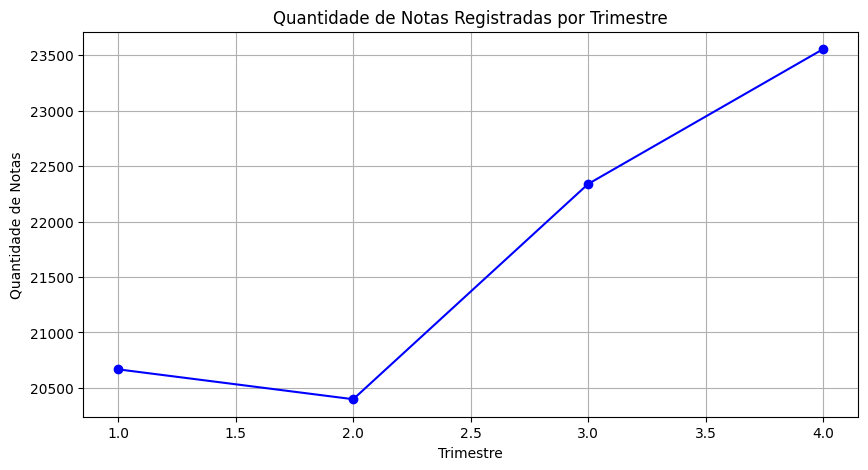

<Figure size 1200x600 with 0 Axes>

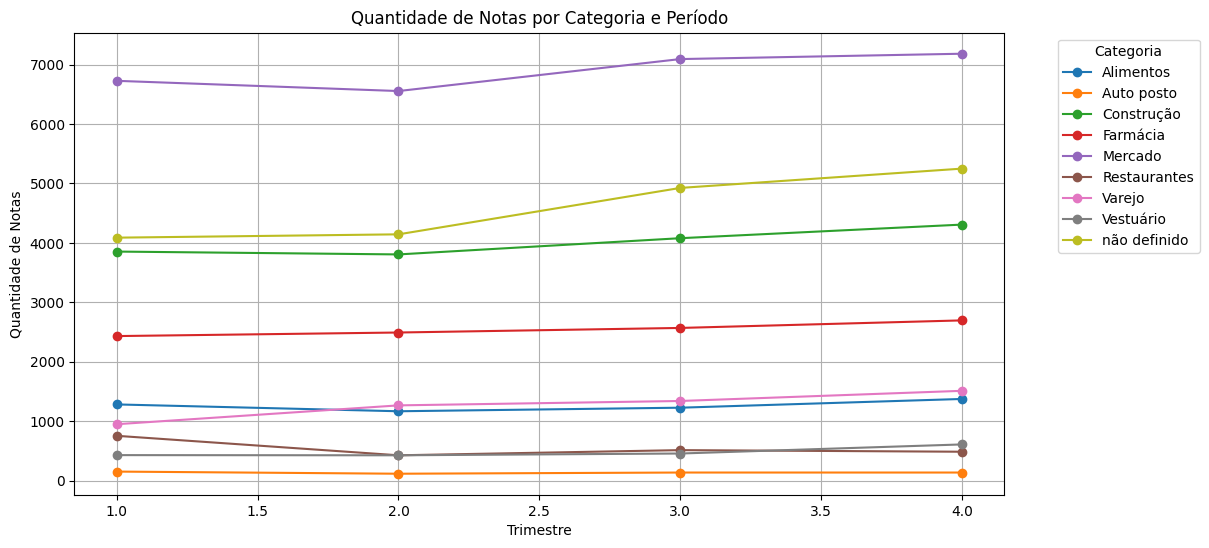

<Figure size 1200x600 with 0 Axes>

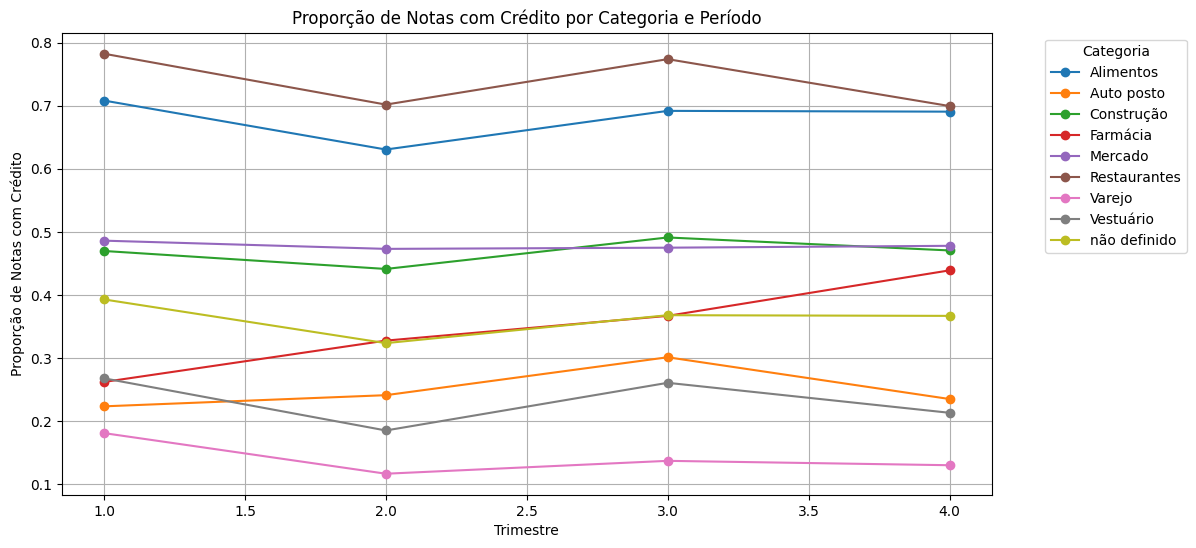

In [12]:
# Análise descritiva no tempo

## Quantidade de notas registradas na base por período
notas_por_trimestre = df_filtered.groupby('Trimestre').size()

plt.figure(figsize=(10,5))
notas_por_trimestre.plot(kind='line', marker='o', color='blue')
plt.xlabel('Trimestre')
plt.ylabel('Quantidade de Notas')
plt.title('Quantidade de Notas Registradas por Trimestre')
plt.grid()
plt.show()

## Quantidade de notas por categoria e por período
notas_categoria_trimestre = df_filtered.groupby(['Trimestre', 'categoria']).size().unstack()

plt.figure(figsize=(12,6))
notas_categoria_trimestre.plot(kind='line', marker='o', figsize=(12,6))
plt.xlabel('Trimestre')
plt.ylabel('Quantidade de Notas')
plt.title('Quantidade de Notas por Categoria e Período')
plt.legend(title='Categoria', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

## Proporção de notas com crédito por categoria por período
credito_categoria_trimestre = df_filtered.groupby(['Trimestre', 'categoria'])['flag_retorno'].mean().unstack()

plt.figure(figsize=(12,6))
credito_categoria_trimestre.plot(kind='line', marker='o', figsize=(12,6))
plt.xlabel('Trimestre')
plt.ylabel('Proporção de Notas com Crédito')
plt.title('Proporção de Notas com Crédito por Categoria e Período')
plt.legend(title='Categoria', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

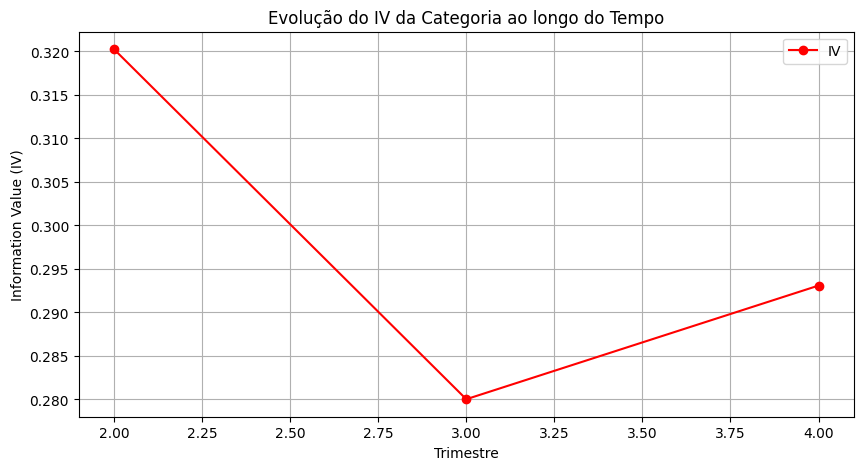

In [16]:
# Avaliação do WOE e IV no tempo
def calculate_woe_iv(df, feature, target):
    df_woe = df.groupby(feature)[target].agg(['sum', 'count']).reset_index()
    df_woe.columns = [feature, 'Eventos', 'Total']
    df_woe['Não Eventos'] = df_woe['Total'] - df_woe['Eventos']
    
    df_woe['Eventos'] = df_woe['Eventos'].replace(0, 0.5)
    df_woe['Não Eventos'] = df_woe['Não Eventos'].replace(0, 0.5)
    
    df_woe['Pct_Eventos'] = df_woe['Eventos'] / df_woe['Eventos'].sum()
    df_woe['Pct_Nao_Eventos'] = df_woe['Não Eventos'] / df_woe['Não Eventos'].sum()
    
    df_woe['WOE'] = np.log(df_woe['Pct_Eventos'] / df_woe['Pct_Nao_Eventos'])
    df_woe['IV'] = (df_woe['Pct_Eventos'] - df_woe['Pct_Nao_Eventos']) * df_woe['WOE']
    iv_value = df_woe['IV'].sum()
    
    return df_woe[[feature, 'WOE']], iv_value

# Calcular WOE e IV por trimestre para a variável categoria
woe_iv_time = {}
for trimestre in df_filtered['Trimestre'].unique():
    df_trim = df_filtered[df_filtered['Trimestre'] == trimestre]
    woe_df, iv_value = calculate_woe_iv(df_trim, 'categoria', 'flag_retorno')
    woe_iv_time[trimestre] = {'woe': woe_df, 'iv': iv_value}

# Converter o índice para um número para evitar problemas de ordenação
iv_trimestre['Trimestre_Num'] = iv_trimestre.index.astype(str).str.extract(r'(\d+)').astype(int)
iv_trimestre = iv_trimestre.sort_values('Trimestre_Num')

# Plotar evolução do IV ao longo do tempo
plt.figure(figsize=(10,5))
plt.plot(iv_trimestre['Trimestre_Num'], iv_trimestre['IV'], marker='o', color='red', label='IV')
plt.xlabel('Trimestre')
plt.ylabel('Information Value (IV)')
plt.title('Evolução do IV da Categoria ao longo do Tempo')
plt.legend()
plt.grid()
plt.show()

## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

### <span style="color:darkblue;"> Conclusões da Análise</span>

#### Quais categorias parecem ter maior proporção de notas com retorno > 0?

A análise da **proporção de notas com crédito por categoria** indica que algumas categorias têm um desempenho superior em termos de retorno de crédito. Os principais destaques são:

- **Restaurantes** e **Alimentos** apresentam as maiores proporções de notas com retorno ao longo do tempo.
- **Auto Posto, Vestuário e Varejo** têm as menores proporções de notas com crédito, sugerindo que esses estabelecimentos emitem mais notas que não geram retorno.

#### Essas diferenças são estáveis ao longo do tempo?

A evolução da **proporção de notas com retorno** por categoria ao longo dos trimestres mostra que:

- A tendência geral das categorias **permanece relativamente estável**, mas há **variações sazonais** que podem estar ligadas a fatores externos, como mudanças regulatórias ou hábitos de consumo.
- **Restaurantes e Alimentos** mantêm uma proporção alta de notas com retorno, reforçando sua estabilidade como categorias de maior benefício dentro do programa.
- Algumas categorias apresentam **flutuações visíveis**, como o **Varejo**, que teve uma queda ao longo do tempo.
  
#### Considerações Finais

- Categorias como **Restaurantes e Alimentos** consistentemente oferecem maiores retornos no programa.
- Há uma estabilidade relativa, mas com **variações sazonais** que precisam ser levadas em conta.
- A evolução do IV sugere que a **categoria continua sendo uma variável preditiva útil**, mas pode perder um pouco de sua força ao longo do tempo.